In [24]:
import os
import datetime
from datetime import date
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import median_absolute_error as MedAE

import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input

import geopandas as gpd
import unidecode
import libpysal
import spopt
from spopt.region import Skater
from sklearn.metrics import pairwise as skm
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns

#### Step 0: Prepare Model Data

In [107]:
def prep_ins_data (folder_CASdata):
        # R code to download R data
    #library(CASdatasets)
    #data(brvehins1a)
    #write.csv(brvehins1a, "brvehins1a.csv", row.names=FALSE)
    # *** repeat for brvehins1b, brvehins1c, brvehins1d, brvehins1e
    # import insurance data
    dfData=pd.DataFrame()
    for filename in ["brvehins1a.csv","brvehins1b.csv","brvehins1c.csv","brvehins1d.csv","brvehins1e.csv"]:
        dfTemp= pd.read_csv(folder_CASdata+filename)[['Gender', 'DrivAge', 'VehYear', 'VehModel', 'VehGroup','Area', 'State',
            'ExposTotal','ClaimNbPartColl','ClaimNbTotColl','ClaimAmountPartColl', 'ClaimAmountTotColl']]
        dfTemp['ClaimNbColl']=dfTemp['ClaimNbPartColl']+dfTemp['ClaimNbTotColl']
        dfTemp['ClaimAmountColl']=dfTemp['ClaimAmountPartColl']+dfTemp['ClaimAmountTotColl']    
        dfTemp.drop(columns=['ClaimNbPartColl','ClaimNbTotColl','ClaimAmountPartColl', 'ClaimAmountTotColl'], inplace=True)
        dfData=pd.concat([dfData, dfTemp], axis=0, ignore_index=True)
        del dfTemp
    # filter out NA
    dfData.dropna(inplace=True)
    # filter out zero exposures
    mask= (dfData['ExposTotal']>0) #filter out the policies have 0 exposure count 
    mask= mask & (dfData['ExposTotal']>14/365) #filter out the policies have exposures less than 2 weeks
    mask= mask & (dfData['Gender']!='Corporate')  # Filter out Gender=='Corporate' (no claim for the group)
    #******************testing******************
    mask= mask & (dfData['ExposTotal']<=1) #filter out the policies exposures greater than 1
    #******************testing******************
    dfData=dfData[mask]

    dfData.rename(columns={'ExposTotal':'Expo', 'ClaimNbColl':'Cnt', 'ClaimAmountColl':'Amt'}, inplace=True)
    dfData['Freq']=dfData['Cnt']/dfData['Expo']
    dfData['Sev']=dfData['Amt']/dfData['Cnt']
    dfData['LossCost']=dfData['Amt']/dfData['Expo']
    return dfData

def prep_geom_data(fname_gdfState, dfData):
    # merge geometric data
    # Geometric data
    # source: https://data.humdata.org/dataset/f5f0648e-f085-4c85-8242-26bf6c942f40/resource/2f26be26-a081-4557-8572-58545cd70e9f/download/bra_adm_ibge_2020_shp.zip
    gdfState=gpd.read_file(fname_gdfState)
    gdfState.loc[gdfState['ADM1_PCODE']=='BR32','ADM1_PT']="Esperito Santo"
    gdfState['ADM1_PT']=gdfState['ADM1_PT'].apply(unidecode.unidecode)
    # merge with original data
    gdfState=gdfState[['ADM1_PT', 'geometry']].set_index('ADM1_PT').join(
        dfData.groupby('State', observed=True)[['Expo','Cnt','Amt']].sum(), how='left'
        ).reset_index().rename(columns={'ADM1_PT':'State'})
    gdfState['Freq']=gdfState['Cnt']/gdfState['Expo']
    gdfState['Sev']=gdfState['Amt']/gdfState['Cnt']
    gdfState['LossCost']=gdfState['Amt']/gdfState['Expo']
    return gdfState

def pre_marge_data(gdfState):
    # pre-merge to meet credibility requirement
    # credibility threshold based on the total number of exposures in a state
    expo_threshold=2500         
    small_state=[]
    neig_state=[]

    # create a weight object to identify contiguous States
    w_rook = libpysal.weights.Rook.from_dataframe(gdfState)
    gdfState['State_merge']=gdfState['State'].copy()
    expo_by_cls = gdfState.groupby('State_merge', observed=True, as_index=False)['Expo'].sum()
    smallest_cls=expo_by_cls.loc[expo_by_cls['Expo'].idxmin(), 'State_merge']
    # test if the smallest states is below credibility thredhold
    while expo_by_cls['Expo'].min()<expo_threshold:  
        smallest_state=gdfState.loc[gdfState['State_merge'] == smallest_cls,].index.values[0]
        small_state.append(smallest_state)
        neighbors = w_rook.neighbors[smallest_state]
        distance = gdfState.loc[neighbors,].distance(gdfState.loc[smallest_state,].geometry.centroid)
        closest_neig=distance.idxmin()
        neig_state.append(closest_neig)
        # combine the state with its closest neighbour
        gdfState.loc[smallest_state,'State_merge'] = gdfState.loc[closest_neig,'State_merge']
        expo_by_cls = gdfState.groupby('State_merge', observed=True, as_index=False)['Expo'].sum()
        smallest_cls=expo_by_cls.loc[expo_by_cls['Expo'].idxmin(), 'State_merge']
        
    gdfCls = gdfState.dissolve(by='State_merge', aggfunc='sum')
    gdfCls['Freq'] = gdfCls['Cnt']/gdfCls['Expo']
    return gdfState
    
def prep_model_data (folder_CASdata, fname_gdfState, fname_dfFull, fname_dfTrain, fname_dfTest):  
    print("Import insurance data ......")
    dfData = prep_ins_data (folder_CASdata)
    print("Import geometric data ......")
    gdfState = prep_geom_data(fname_gdfState, dfData)
    print("Pre-merge insurance data ......")
    gdfState = pre_marge_data(gdfState) 
        
    # add the pre-merged States (State_merge) into original data save
    dfFull=dfData.merge(gdfState[['State','State_merge']], on='State', how='left')
    # 70/30 split for train/test data
    train,test = train_test_split(dfFull, test_size=0.3, random_state=42)

    print("Save pre-processed data ......")
    # save the data for next step
    dfFull.to_csv(fname_dfFull)
    train.to_csv(fname_dfTrain)
    test.to_csv(fname_dfTest)    

In [108]:
folder_CASdata='data/CASDatasets/'
fname_gdfState='data/bra_adm_ibge_2020_shp/bra_admbnda_adm1_ibge_2020.shp'
fname_dfFull = 'data/model_full.csv'
fname_dfTrain = 'data/model_train.csv'
fname_dfTest = 'data/model_test.csv'


prep_model_data (folder_CASdata, fname_gdfState, fname_dfFull, fname_dfTrain, fname_dfTest)

Import insurance data ......
Import geometric data ......
Pre-merge insurance data ......


C:\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  warnings.warn(message)


Save pre-processed data ......


In [115]:
fname_dfFull = 'data/model_full.csv'
dfTemp=pd.read_csv(fname_dfFull, index_col=0)
dfTemp.describe()


,VehYear,Expo,Cnt,Amt,Freq,Sev,LossCost
count,777313.000000,777313.000000,777313.000000,777313.000000,777313.000000,22745.000000,7.773130e+05
mean,2004.383386,0.467227,0.030801,285.483563,0.074647,9402.262428,8.021751e+02
std,5.533065,0.238614,0.182236,3536.126779,0.633379,17829.661214,1.522170e+04
min,1881.000000,0.040000,0.000000,0.000000,0.000000,1.000000,0.000000e+00
25%,2001.000000,0.300000,0.000000,0.000000,0.000000,1552.000000,0.000000e+00
50%,2006.000000,0.500000,0.000000,0.000000,0.000000,3445.000000,0.000000e+00
75%,2009.000000,0.500000,0.000000,0.000000,0.000000,8591.000000,0.000000e+00
max,2012.000000,1.000000,6.000000,357403.000000,50.000000,357403.000000,3.010725e+06


In [120]:
#(dfTemp['Cnt']==0).sum()/dfTemp.shape[0]
dfTemp['Cnt'].sum()/dfTemp['Expo'].sum()

0.06592294141765602

## ***********************************************************************************
## Boosting Process
    1. GLM 1: Cnt ~ Numerical + Low Cat Var -> residual deviance r_1
    2. Nnet Model 1: r_1 = g(HC) -> 10 features for HC variable
    3. GLM 2: Cnt ~ Numerical + Low Cat Var + HC_F0 + ... + HC_F9 -> residual deviance r_2
    4. Nnet Model 2: r_2 = g(Loc) -> 3 features for Loc variable
    5. Spatial-Constraint Clustering model using the features for Loc variable -> Territory
    6. GLM 3: Cnt ~ Numerical + Low Cat Var + Territory -> residual deviance r_3
    7. Nnet Model 3: r_3 = g(HC) -> 10 features for HC variable
    8. GLM 4 (Final Nested GLM): Cnt ~ Numerical + Low Cat Var + Territory + HC_F0 + ... + HC_F9
## ***********************************************************************************

In [9]:
def update_GLM_model (data, expr_, expo_col): 
        # use GLM residual as targets for Nnet
    mod_p = smf.glm(formula=expr_, data=data, offset=np.log(data[expo_col]), 
                     family=sm.families.Poisson(link=sm.families.links.Log()))
    res_p=mod_p.fit()
    return res_p.resid_deviance

def prep_Nnet_data (data, cat_col_list, expr_, expo_col): 
    # convert categorical values to integers using categorical code
    if isinstance(cat_col_list, str):
        cat_col_list=[cat_col_list]
    for cat_col in cat_col_list:
        cat_col_old=cat_col
        cat_col=cat_col+'Code'
        data[cat_col]=data[cat_col_old].astype('category').cat.codes
    train = data

    # use category codes for each categorical feature as input for nnet model
    inputs=[]
    for cat_col in cat_col_list:
        inputs.append(tf.constant((train[cat_col+'Code']), dtype=tf.int32))

    targets = tf.constant(update_GLM_model (data, expr_, expo_col), dtype=tf.float32)

    print("NNET data ready")
    return [inputs, targets], train

# Define EmbeddingNN model using the Keras API in TensorFlow
def create_model(num_categories_list, embedding_dim_list, hidden_sizes, activation_function):
    
    check_list = lambda var: [var] if not isinstance(var, list) else var
    num_categories_list = check_list(num_categories_list)
    embedding_dim_list = check_list(embedding_dim_list)
    hidden_sizes = check_list(hidden_sizes)
    
    num_hidden_layers=len(hidden_sizes)
    inputs = []
    embeddings = []
    
    # Create separate input layer for each categorical feature
    for i, num_categories in enumerate(num_categories_list):
        input_layer = Input(shape=(1,), dtype='int32')
        inputs.append(input_layer)
        
        embedding_layer = Embedding(input_dim=num_categories, output_dim=embedding_dim_list[i],
                                    input_length=1, name='category_embeddings_'+str(i))(input_layer)
        flatten_layer = Flatten()(embedding_layer)
        embeddings.append(flatten_layer)   
    # Concatenate the embeddings from all categorical features
    combined_embeddings = tf.keras.layers.concatenate(embeddings)
    concatenated_inputs = combined_embeddings
    # Add multiple hidden layers
    for i in range(num_hidden_layers):
        print("layer {:d} with {:d} nodes".format(i,hidden_sizes[i] ))
        concatenated_inputs = Dense(hidden_sizes[i], use_bias=False, activation=activation_function)(concatenated_inputs)  
    output = Dense(1, use_bias=False, activation='linear')(concatenated_inputs)    
   
    model = Model(inputs=inputs, outputs=output)  
    return model

# Run nnet model and generate the weights for each categorical level
# target= GLM residule, inputs= categorical levels
def extract_cat_features(train_data, data, cat_col,
                         num_categories, embedding_size, hidden_size, activation_function,
                         learning_rate, loss_function, patience, epochs, batch_size,
                        random_seed=0):
    
    tf.random.set_seed (random_seed)
    inputs, targets = train_data
    print("creating nnet model at ", datetime.datetime.now()) 
    model = create_model(num_categories, embedding_size, hidden_size, activation_function)
    optimizer     = optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=loss_function)
    early_stopping_callback = callbacks.EarlyStopping(patience=patience, restore_best_weights=True, verbose=1, mode="min")
    history = model.fit(inputs, targets,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.2, 
                            callbacks=[early_stopping_callback], 
                            verbose=0,
                        )   
    #feature extraction from the second-to-last layer
    penultimate_layer = model.layers[-2]
    feature_extraction_model = Model(inputs=model.input, outputs=penultimate_layer.output)
    features = feature_extraction_model.predict(inputs)
    
    # Get unique combined categories
    unique_categories_cat, category_indices_cat = np.unique(data[cat_col], return_inverse=True)
    # minor difference for the values potentially due to interal rounding
    features_cat = np.vstack([np.mean(features[category_indices_cat == i, :], axis=0) for i in range(len(unique_categories_cat))])
    pdFeature_cat = pd.DataFrame(
                        np.hstack((unique_categories_cat[:,None], features_cat))
                        , columns=[cat_col, *[cat_col+'_f'+str(i) for i in range(features_cat.shape[1])]])
    for c in pdFeature_cat.columns[1:]:
        pdFeature_cat[c]=pd.to_numeric(pdFeature_cat[c])
    return pdFeature_cat

In [83]:
def prep_test_GLM_data(dfTrain_before, dfTest_before, dfFeature, cat_col):
    feature_col=[c for c in dfFeature.columns[1:]]
    train_after = dfTrain_before.merge(dfFeature, on=cat_col, how='left')
    test_after = dfTest_before.merge(dfFeature, on=cat_col, how='left')
    
    train_after[feature_col] = train_after[feature_col].fillna(train_after[feature_col].mean())
    test_after[feature_col]  = test_after[feature_col].fillna(test_after[feature_col].mean())
    return train_after, test_after, feature_col

def GLM_scores(dfTrain, dfTest, glm_expr):

    FreqPoisson = smf.glm(formula=glm_expr, data=dfTrain, offset=np.log(dfTrain['Expo']), 
                     family=sm.families.Poisson(link=sm.families.links.Log())).fit()
    
    pred_test=FreqPoisson.predict(dfTest, offset=np.log(dfTest.loc[:,'Expo']))

    glm_score=[FreqPoisson.deviance, FreqPoisson.bic_llf, FreqPoisson.aic]
    score=[
        100*MSE(y_true=dfTrain.loc[:,'Cnt'], y_pred=FreqPoisson.fittedvalues),
        100*MSE(y_true=dfTest.loc[:,'Cnt'], y_pred=pred_test),
        100*MAE(y_true=dfTrain.loc[:,'Cnt'], y_pred=FreqPoisson.fittedvalues),
        100*MAE(y_true=dfTest.loc[:,'Cnt'], y_pred=pred_test),
        100*MedAE(y_true=dfTrain.loc[:,'Cnt'], y_pred=FreqPoisson.fittedvalues),
        100*MedAE(y_true=dfTest.loc[:,'Cnt'], y_pred=pred_test),
    ]
    glm_index=['Deviance','BIC','AIC']
    score_index=['MSE_train (x100)','MSE_test (x100)','MAE_train (x100)','MAE_test (x100)','MedianAE_train (x100)','MedianAE_test (x100)']
    GLM_perf = pd.concat([pd.DataFrame(glm_score, index=glm_index).round(decimals=0),
           pd.DataFrame(score, index=score_index).round(decimals=6)]).transpose()
    GLM_perf['Model']=glm_expr
    return GLM_perf

In [85]:
fname_dfTrain = 'data/model_train.csv'
data=pd.read_csv(fname_dfTrain, index_col=0).head(1000)
fname_dfTest = 'data/model_test.csv'
test_data=pd.read_csv(fname_dfTest, index_col=0).head(1000)
today = str(date.today()) 
output_fname='results/'+today
expo_col ='Expo'
HC_col   = 'VehGroup' 
geo_col  = 'State_merge'
data[geo_col] = data[geo_col].astype('category')
data_seed= 42
num_categories_HC = data[HC_col].nunique() #435
epochs        = 100
batch_size    = 64
learning_rate = 0.001
patience      = 5
embedding_size = 1
hidden_size_HC   = [210, 105, 50, 25, 10] #feature extraction dim = 10
num_categories_geo = data[geo_col].nunique() #24
hidden_size_geo   = [70, 35, 15, 7, 3] #feature extraction dim = 3
loss_function = losses.MeanSquaredError()
activation_function='sigmoid'

#GLM 1
GLM_expr_    ='Cnt ~ VehYear + Gender * DrivAge'
train_data, train = prep_Nnet_data (data, HC_col, GLM_expr_, expo_col)
GLM_scores(data, test_data, GLM_expr_).to_csv(
    output_fname+'_glm_scores.csv')

#2 - feature extraction for HC variable
print("extracting features at ", datetime.datetime.now()) 
pdFeature_HC = extract_cat_features(train_data, data, HC_col,
                     num_categories_HC, embedding_size, hidden_size_HC, activation_function,
                     learning_rate, loss_function, patience, epochs, batch_size)
pdFeature_HC.to_csv(output_fname+'_HC_features_1.csv')

# 3. update GLM model using extracted feature for HC varaible & prepare for loc varaible nnet model
print("updating GLM scores at ", datetime.datetime.now()) 
update_data, updated_test_data, feature_col = prep_test_GLM_data(data, test_data, pdFeature_HC, HC_col)
updated_GLM_expr_ = ' + '.join([GLM_expr_,*feature_col])
GLM_scores(update_data, updated_test_data, updated_GLM_expr_).to_csv(
    output_fname+'_glm_scores.csv', mode = 'a', header= False)
update_train_data, update_train = prep_Nnet_data (update_data, geo_col, updated_GLM_expr_, expo_col)

#4 - feature extraction for loc variable
print("extracting features at ", datetime.datetime.now()) 
pdFeature_geo = extract_cat_features(update_train_data, data, geo_col,
                     num_categories_geo, embedding_size, hidden_size_geo, activation_function,
                     learning_rate, loss_function, patience, epochs, batch_size)
pdFeature_geo.to_csv(output_fname+'_geo_features.csv')
print("updating GLM scores at ", datetime.datetime.now()) 
update_data, updated_test_data, feature_col = prep_test_GLM_data(update_data, updated_test_data, pdFeature_geo, geo_col)
updated_GLM_expr_ = ' + '.join([updated_GLM_expr_,*feature_col])
GLM_scores(update_data, updated_test_data, updated_GLM_expr_).to_csv(
    output_fname+'_glm_scores.csv', mode = 'a', header= False)


NNET data ready
extracting features at  2023-12-20 00:31:54.072735
creating nnet model at  2023-12-20 00:31:54.072735
layer 0 with 210 nodes
layer 1 with 105 nodes
layer 2 with 50 nodes
layer 3 with 25 nodes
layer 4 with 10 nodes
Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping
32/32 [==============================] - 0s 3ms/step
updating GLM scores at  2023-12-20 00:31:57.247276
NNET data ready
extracting features at  2023-12-20 00:31:57.627678
creating nnet model at  2023-12-20 00:31:57.627678
layer 0 with 70 nodes
layer 1 with 35 nodes
layer 2 with 15 nodes
layer 3 with 7 nodes
layer 4 with 3 nodes
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
32/32 [==============================] - 0s 2ms/step
updating GLM scores at  2023-12-20 00:32:00.841142


#### Model 5: Spatial Constraint Clustering

In [33]:
def WCSS_score (data, cluster_labels):
    unique_labels = np.unique(cluster_labels)
    wcss = 0
    for label in unique_labels:
        cluster_points = data[cluster_labels == label]
        centroid = np.mean(cluster_points)
        squared_distances = np.sum((cluster_points - centroid) ** 2)
        wcss += np.sum(squared_distances)
    return wcss

In [109]:
# import features for location variable
fname='results/2023-12-20_geo_features.csv'
Loc_Feature = pd.read_csv(fname,index_col=0)
geo_col  = 'State_merge'
Loc_f_col=[x for x in Loc_Feature.columns if x !=geo_col]

# Geometric data
# source: https://data.humdata.org/dataset/f5f0648e-f085-4c85-8242-26bf6c942f40/resource/2f26be26-a081-4557-8572-58545cd70e9f/download/bra_adm_ibge_2020_shp.zip
gdfState=gpd.read_file('data/bra_adm_ibge_2020_shp/bra_admbnda_adm1_ibge_2020.shp')
gdfState.loc[gdfState['ADM1_PCODE']=='BR32','ADM1_PT']="Esperito Santo"
gdfState['ADM1_PT']=gdfState['ADM1_PT'].apply(unidecode.unidecode)

train=pd.read_csv('data/model_train.csv', index_col=0)

# combine the geometric information, nnet weight for each state (after pre-merged)
gdfState=gdfState.merge(train[['State',geo_col]].drop_duplicates(), left_on='ADM1_PT', right_on='State', how='left'
                       )[['geometry','State',geo_col]]
gdfState=gdfState.merge(Loc_Feature, on=geo_col)
gdfCls=gdfState.drop(columns=['State']).dissolve(by=geo_col, as_index=False)

# create connectivity matrix
# Rook neighbors are those states that share an edge on their respective borders - more appropriate
# Queen neighbors are based on a more inclusive condition that requires only a shared vertex (point) between two states:
w_rook = libpysal.weights.Rook.from_dataframe(gdfCls)

gdfCls_island=gdfCls.iloc[w_rook.islands,]
gdfCls_rm_island=gdfCls.drop(w_rook.islands, axis=0).reset_index().drop('index', axis=1)
w_rook_rm_island = libpysal.weights.Rook.from_dataframe(gdfCls_rm_island)


C:\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 4.
  warnings.warn(message)


C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


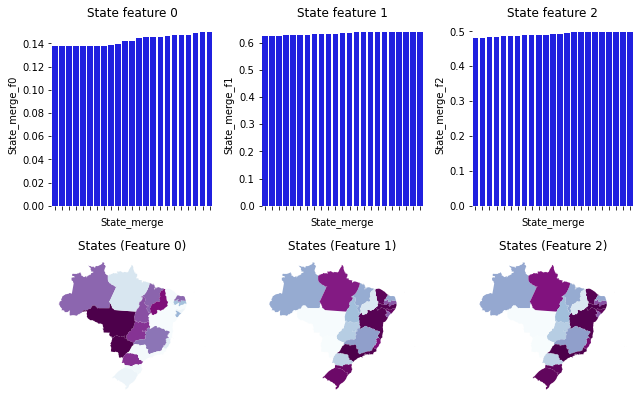

In [110]:
fig,axs=plt.subplots(2,len(Loc_f_col),figsize=(3*len(Loc_f_col),3*2),sharex=False, sharey=False)

for i, c in enumerate(Loc_f_col):
    sns.barplot(data=Loc_Feature,x=geo_col, y=c,
                order=Loc_Feature.sort_values(by=c)[geo_col], ax=axs[0,i],color='blue'
               ).set(title='State feature '+str(i), xticklabels=[])

    gdfCls.plot(column=c, cmap='BuPu',legend=False, ax=axs[1,i])
    axs[1,i].set_title('States (Feature {:d})'.format(i),fontsize=12)
    axs[1,i].xaxis.set_tick_params(labelbottom=False)
    axs[1,i].yaxis.set_tick_params(labelleft=False)
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])

sns.despine(left=True, bottom=True, right=True)
plt.tight_layout()
#plt.savefig('ppt_jpeg/jupyter_output/State_CE_wtd_map.jpeg', bbox_inches='tight', dpi=1200)

plt.tight_layout()
#plt.savefig('ppt_jpeg/jupyter_output/NNET_CE_wtds.jpeg', bbox_inches='tight',dpi=1200)
plt.show();

C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: Futu

C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3462: Futu

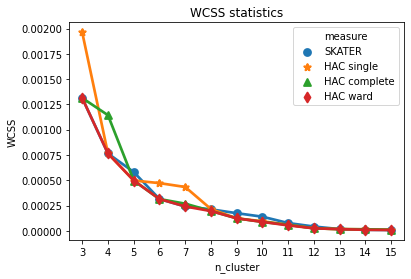

In [111]:
methods=['SKATER','HAC']
linkages=['single', 'complete', 'ward']
markers=['o', '*', '^', 'd']
dfWCSS=pd.DataFrame()
spanning_forest_kwds = dict(
                            dissimilarity=skm.euclidean_distances,
                            affinity=None,
                            reduction=np.sum,
                            center=np.mean,
                            verbose=0
                            )
fig,ax=plt.subplots()

for m, method in enumerate (methods):
    WCSS=[]
    n_cluster=[]
    label=[]
    for n_cls_ in range(2, 15):
        if m==0:
            model = Skater(
                gdf=gdfCls_rm_island, w=w_rook_rm_island, attrs_name=Loc_f_col, n_clusters=n_cls_, floor=-np.inf, trace=False, 
                islands='ignore', spanning_forest_kwds=spanning_forest_kwds
            )
            model.solve()
            cluster_label=np.array(model.labels_)
            WCSS.append(WCSS_score(gdfCls_rm_island[Loc_f_col],cluster_label)) 
            n_cluster.append(len(np.unique(cluster_label)))
            label.append(method)

        else:
            for l, linkage_ in enumerate(linkages):
                cluster_HAC = AgglomerativeClustering(n_clusters=n_cls_,affinity='euclidean', 
                                                      connectivity = w_rook_rm_island.full()[0],
                                                      linkage=linkage_).fit(gdfCls_rm_island[Loc_f_col])
                cluster_label=np.array(cluster_HAC.labels_)
                WCSS.append(WCSS_score(gdfCls_rm_island[Loc_f_col],cluster_label)) 
                n_cluster.append(len(np.unique(cluster_label)))
                label.append(method+" "+linkage_)
    dfTemp=pd.DataFrame({'measure':label, 'n_cluster':[n + len(w_rook.islands) for n in n_cluster], 'WCSS':WCSS})
    dfWCSS=pd.concat([dfWCSS,dfTemp], axis=0)
sns.pointplot(x='n_cluster',y='WCSS', hue='measure', data=dfWCSS, markers=markers, dodge=0.0001).set(
    title='WCSS statistics');
#fig.savefig('fig/jupyter_output/3_Cls_results.jpeg', bbox_inches='tight', dpi=1200)


In [112]:
n_cls_= 12 - len(w_rook.islands)  #optimal number of clusters from WSCC plot minus # of islands
methods=['SKATER','HAC']
linkages=['single', 'complete', 'ward']
dfCls=pd.DataFrame()
spanning_forest_kwds = dict(
                            dissimilarity=skm.euclidean_distances,
                            affinity=None,
                            reduction=np.sum,
                            center=np.mean,
                            verbose=0
                            )
for m, method in enumerate(methods):
    if m==0:
        model = Skater(
            gdf=gdfCls_rm_island, w=w_rook_rm_island, attrs_name=Loc_f_col, n_clusters=n_cls_, floor=-np.inf, trace=False, 
            islands='ignore', spanning_forest_kwds=spanning_forest_kwds
        )
        model.solve()
        cluster_label=np.array(model.labels_, dtype='object')
        dfCls[method]=cluster_label
    else:
        for linkage_ in linkages:
            cluster_HAC = AgglomerativeClustering(n_clusters=n_cls_,affinity='euclidean', 
                                                  connectivity = w_rook_rm_island.full()[0],
                                                  linkage=linkage_).fit(gdfCls_rm_island[Loc_f_col])
            cluster_label=np.array(cluster_HAC.labels_, dtype='object')
            dfCls[method+"_"+linkage_]=cluster_label

for c in dfCls.columns:
    gdfCls_island[c]=n_cls_
    for i, idx in enumerate(gdfCls_island.index):
        gdfCls_island.loc[idx,c]=gdfCls_island.loc[idx,c]+i+1

gdfCluster = pd.concat([pd.concat([gdfCls_rm_island,dfCls], axis=1)
                        ,gdfCls_island], axis=0).reset_index().drop('index', axis=1)



C:\Python310\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Python310\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Python310\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

C:\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


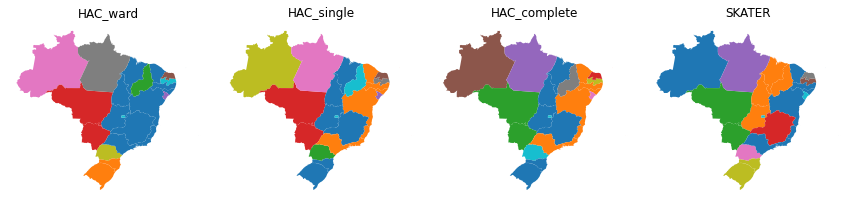

In [113]:
columns=['HAC_ward', 'HAC_single', 'HAC_complete', 'SKATER']

fig,axs=plt.subplots(1,4,figsize=(3*4,3*1),sharex=True, sharey=True)
for i, c in enumerate(columns):
    gdfCluster.plot(column=c,cmap='tab10',legend=False, ax=axs[i])
    axs[i].set_title(c,fontsize=12)
    axs[i].xaxis.set_tick_params(labelbottom=False)
    axs[i].yaxis.set_tick_params(labelleft=False)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

sns.despine(left=True, bottom=True, right=True)
plt.tight_layout()
#plt.savefig('ppt_jpeg/jupyter_output/Cls_plot_methods_flat.jpeg', bbox_inches='tight', dpi=1200)
plt.show()

In [114]:
sel_method='HAC_ward'
train=pd.read_csv('data/model_train.csv', index_col=0)
test=pd.read_csv('data/model_test.csv', index_col=0)

train_terr=train.merge(gdfCluster[[geo_col,sel_method]], how='left').rename(columns={sel_method:'Territory'})
test_terr=test.merge(gdfCluster[[geo_col,sel_method]], how='left').rename(columns={sel_method:'Territory'})

train_terr.to_csv('data/train_terr.csv', header=True)
test_terr.to_csv('data/test_terr.csv', header=True)

#### Model 6: GLM with Territory; Model 7: NNet to extract Veh Feature

In [ ]:
train_terr=pd.read_csv('data/train_terr.csv', index_col=0)
test_terr=pd.read_csv('data/test_terr.csv', index_col=0)
Loc_Feature = pd.read_csv(output_fname+'_geo_features.csv',index_col=0)

data     = train_terr
expo_col = 'Expo'
HC_col   = 'VehGroup' 
geo_col  = 'State_merge'
data[geo_col] = data[geo_col].astype('category')
data_seed= 42

num_categories_HC = data[HC_col].nunique() #435
epochs        = 100
batch_size    = 64
learning_rate = 0.001
patience      = 5
embedding_size = 1
hidden_size_HC   = [210, 105, 50, 25, 10] #feature extraction dim = 10
loss_function = losses.MeanSquaredError()
activation_function='sigmoid'

# Model 6 -  GLM model and prepare NNET for HC variable
GLM_expr_T= 'Cnt ~ VehYear + Gender * DrivAge + Territory'
train_data, train = prep_Nnet_data (data, HC_col, GLM_expr_T, expo_col)

#Model 7 - feature extraction for HC variable
print("initiating NNET at ", datetime.datetime.now()) 
print("extracting features at ", datetime.datetime.now()) 
pdFeature_HC = extract_cat_features(train_data, data, HC_col,
                     num_categories_HC, embedding_size, hidden_size_HC, activation_function,
                     learning_rate, loss_function, patience, epochs, batch_size)
pdFeature_HC.to_csv(output_fname+'_HC_features_2.csv')


##### Model 8: GLM with Territory & Veh Feature

In [28]:
print("updating GLM scores at ", datetime.datetime.now()) 
train_final, test_final, feature_col = prep_test_GLM_data(train_terr, test_terr, pdFeature_HC, HC_col)

updated_GLM_expr_ = ' + '.join([GLM_expr_T,*feature_col])
GLM_scores(train_final, test_final, updated_GLM_expr_).to_csv(
    output_fname+'_glm_scores.csv', mode = 'a', header= False)


,Deviance,BIC,AIC,RMSE_train,RMSE_test,RMAE_train,RMAE_test
Model_1,448408.0,743841.0,743712.0,300.121492,26.888490,0.768701,0.753048
+VehGroup(wtds),445334.0,740782.0,740641.0,247.981643,19.977311,0.770342,0.749485
+VehGroup (wtds) + State (OHE),436336.0,732114.0,731690.0,286.955477,15.863036,0.736951,0.724550
+VehGroup (wtds) + State (wtds),441736.0,737198.0,737045.0,307.426667,17.564071,0.753755,0.739214
+VehGroup (wtds) + Territory,442855.0,738399.0,738176.0,282.188577,18.223211,0.762579,0.736721


In [60]:
fname_dfFull = 'data/model_full.csv'
dfTemp=pd.read_csv(fname_dfFull, index_col=0)
dfTemp.head()

,Gender,DrivAge,VehYear,VehModel,VehGroup,Area,State,Expo,Cnt,Amt,Freq,Sev,LossCost,State_merge
0,Male,26-35,1998.0,Vw - Volkswagen - Gol Gl 1.6 Mi/star 1.6 E 1.8...,Vw Volkswagen Gol Acima De 1.0,Met. Porto Alegre e Caxias do Sul,Rio Grande do Sul,1.00,1,2773.0,1.0,2773.0,2773.0,Rio Grande do Sul
1,Male,36-45,2010.0,Volvo - C30 2.0 145cv,Volvo - Outros,Triangulo mineiro,Minas Gerais,0.25,0,0.0,0.0,NaN,0.0,Minas Gerais
2,Female,26-35,2002.0,Fiat - Uno Mille 1.0 Fire/ F.flex/ Economy 4p,Fiat Uno 1.0,Demais regioes,Rio Grande do Sul,0.93,0,0.0,0.0,NaN,0.0,Rio Grande do Sul
3,Female,36-45,2006.0,Honda - Cg 150 Sport,Honda Motos Ate 450cc,Grande Campinas,Sao Paulo,0.50,0,0.0,0.0,NaN,0.0,Sao Paulo
4,Male,46-55,2005.0,Gm - Chevrolet - Zafira Elite 2.0 Mpfi 16v 136...,Gm Chevrolet Zafira,Met.BH-Centro Oeste-Zona Mata-C. Vertentes,Minas Gerais,0.70,0,0.0,0.0,NaN,0.0,Minas Gerais


In [86]:
train_terr.head(3)

,Gender,DrivAge,VehYear,VehModel,VehGroup,Area,State,Expo,Cnt,Amt,Freq,Sev,LossCost,State_merge,Territory
0,Female,36-45,2006.0,Renault - Clio Sed.rt/privil.1.0/1.0 Hi-pow.16...,Renault Clio 1.0,Pernambuco,Pernambuco,0.72,0,0.0,0.0,NaN,0.0,Pernambuco,0
1,Female,26-35,1996.0,Fiat - Palio 1.6 Mpi 16v 4p,Fiat Palio Acima De 1.0,Vale do Paraiba e Ribeira,Sao Paulo,0.93,0,0.0,0.0,NaN,0.0,Sao Paulo,0
2,Male,18-25,1998.0,Fiat - Siena Hl 1.6 Mpi 16v,Fiat Siena Acima De 1.0,Met. Porto Alegre e Caxias do Sul,Rio Grande do Sul,0.50,0,0.0,0.0,NaN,0.0,Rio Grande do Sul,2


In [63]:

dfTemp.loc[dfTemp['Expo']<=1, 'State_merge'].nunique()

23

In [57]:

dfTemp.loc[:, 'VehGroup'].nunique()

430